# 03. Feature Engineering for Vehicle Accessories Recommendation

## Objectives:
1. **Create derived features** from existing data
2. **Extract price segments** for both cars and accessories
3. **Create accessory categories** for better recommendations
4. **Process reviews** for sentiment analysis preparation
5. **Generate compatibility matrices**
6. **Create TF-IDF features** from descriptions
7. **Save engineered features** for ML models

**Input**: Cleaned datasets from Phase 1.2  
**Output**: Feature-enriched datasets ready for ML

## 1. Load Cleaned Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("LOADING CLEANED DATASETS")
print("=" * 80)

# Load cleaned datasets
df_cars = pd.read_csv('../../Dataset/processed/cars_cleaned.csv')
df_accessories = pd.read_csv('../../Dataset/processed/accessories_cleaned.csv')

print(f"\n✅ Loaded {len(df_cars)} cars")
print(f"✅ Loaded {len(df_accessories)} accessories")
print(f"\nCars columns: {list(df_cars.columns)}")
print(f"Accessories columns: {list(df_accessories.columns)}")

LOADING CLEANED DATASETS

✅ Loaded 205 cars
✅ Loaded 1739 accessories

Cars columns: ['Car_ID', 'Brand', 'Model', 'Fuel_Type', 'Transmission', 'Year', 'Engine_Size_L', 'Seats', 'Body_Type', 'Price_Range_Lakh', 'Brand_Normalized']
Accessories columns: ['Accessory_ID', 'Car Brand', 'Car Model', 'Accessory Name', 'Accessory Price', 'Accessory Description', 'Compatible Cars', 'Top 5 Reviews', 'Brand_Normalized']


## 2. Create Price Segments for Cars

CREATING PRICE SEGMENTS FOR CARS

✅ Extracted price features:
          Brand      Model Price_Range_Lakh  Price_Min_Lakh  Price_Max_Lakh  \
0  Aston Martin    Vantage    399.00-450.00          399.00          450.00   
1  Aston Martin        DBX    550.00-650.00          550.00          650.00   
2          Audi  Q8 e-tron    115.00-127.00          115.00          127.00   
3          Audi         Q8    117.00-125.00          117.00          125.00   
4          Audi       RS 5    150.00-170.00          150.00          170.00   
5          Audi         A8    156.00-175.00          156.00          175.00   
6          Audi  e-tron GT    172.00-205.00          172.00          205.00   
7          Audi      RS Q8    220.00-250.00          220.00          250.00   
8          Audi         A3      38.00-42.00           38.00           42.00   
9          Audi         Q3      45.24-55.64           45.24           55.64   

   Price_Mid_Lakh  
0          424.50  
1          600.00  
2       

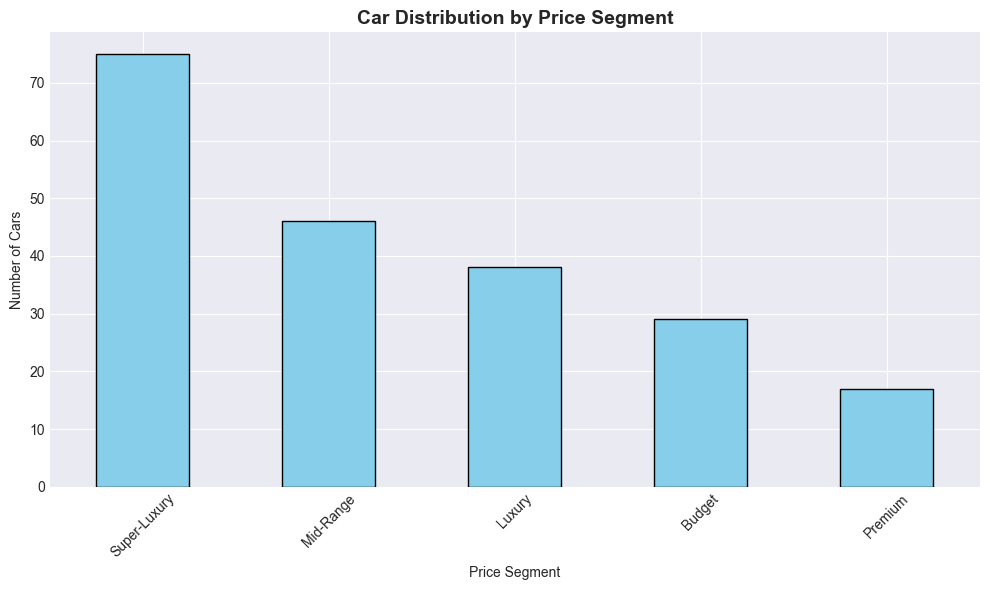


✅ Created Price_Segment feature for cars


In [2]:
print("=" * 80)
print("CREATING PRICE SEGMENTS FOR CARS")
print("=" * 80)

# Extract min and max prices from Price_Range_Lakh
# Format: "10-15" or "50+" or "100"
def extract_price_features(price_range):
    """Extract min, max, and mid price from price range string"""
    if pd.isna(price_range):
        return None, None, None
    
    price_str = str(price_range).strip().replace('₹', '').replace('L', '').strip()
    
    # Handle "50+" format
    if '+' in price_str:
        min_price = float(price_str.replace('+', ''))
        max_price = min_price * 1.5  # Estimate
        mid_price = (min_price + max_price) / 2
    # Handle range format "10-15"
    elif '-' in price_str:
        parts = price_str.split('-')
        min_price = float(parts[0])
        max_price = float(parts[1])
        mid_price = (min_price + max_price) / 2
    # Handle single value
    else:
        min_price = float(price_str)
        max_price = min_price
        mid_price = min_price
    
    return min_price, max_price, mid_price

# Apply price extraction
df_cars[['Price_Min_Lakh', 'Price_Max_Lakh', 'Price_Mid_Lakh']] = df_cars['Price_Range_Lakh'].apply(
    lambda x: pd.Series(extract_price_features(x))
)

print(f"\n✅ Extracted price features:")
print(df_cars[['Brand', 'Model', 'Price_Range_Lakh', 'Price_Min_Lakh', 'Price_Max_Lakh', 'Price_Mid_Lakh']].head(10))

# Create price segments based on mid price
def categorize_price(price):
    """Categorize car price into segments"""
    if pd.isna(price):
        return 'Unknown'
    elif price < 10:
        return 'Budget'  # < 10L
    elif price < 20:
        return 'Mid-Range'  # 10-20L
    elif price < 40:
        return 'Premium'  # 20-40L
    elif price < 80:
        return 'Luxury'  # 40-80L
    else:
        return 'Super-Luxury'  # 80L+

df_cars['Price_Segment'] = df_cars['Price_Mid_Lakh'].apply(categorize_price)

print(f"\n📊 Price Segment Distribution:")
print(df_cars['Price_Segment'].value_counts().sort_index())

# Visualize
plt.figure(figsize=(10, 6))
df_cars['Price_Segment'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Car Distribution by Price Segment', fontsize=14, fontweight='bold')
plt.xlabel('Price Segment')
plt.ylabel('Number of Cars')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n✅ Created Price_Segment feature for cars")

## 3. Create Price Segments for Accessories

In [3]:
print("=" * 80)
print("CREATING PRICE SEGMENTS FOR ACCESSORIES")
print("=" * 80)

# Create price segments for accessories
def categorize_accessory_price(price):
    """Categorize accessory price into segments"""
    if pd.isna(price):
        return 'Unknown'
    elif price < 500:
        return 'Very Low'  # < ₹500
    elif price < 2000:
        return 'Low'  # ₹500-2000
    elif price < 5000:
        return 'Medium'  # ₹2000-5000
    elif price < 15000:
        return 'High'  # ₹5000-15000
    else:
        return 'Very High'  # ₹15000+

df_accessories['Price_Segment'] = df_accessories['Accessory Price'].apply(categorize_accessory_price)

print(f"\n📊 Accessory Price Segment Distribution:")
print(df_accessories['Price_Segment'].value_counts())

# Statistics by price segment
print(f"\n📈 Price Statistics by Segment:")
price_stats = df_accessories.groupby('Price_Segment')['Accessory Price'].agg(['count', 'mean', 'min', 'max'])
print(price_stats)

print(f"\n✅ Created Price_Segment feature for accessories")

CREATING PRICE SEGMENTS FOR ACCESSORIES

📊 Accessory Price Segment Distribution:
Price_Segment
Very Low     669
Low          568
Medium       316
High         176
Very High     10
Name: count, dtype: int64

📈 Price Statistics by Segment:
               count          mean      min      max
Price_Segment                                       
High             176   6665.446591   5099.0  12566.0
Low              568   1153.131338    500.0   1999.0
Medium           316   3634.490981   2000.0   4999.0
Very High         10  23050.836000  15050.0  32278.0
Very Low         669    327.522167     89.0    499.0

✅ Created Price_Segment feature for accessories


## 4. Create Accessory Categories

CREATING ACCESSORY CATEGORIES

📊 Accessory Category Distribution:
Category
Interior       945
Exterior       274
Protection     236
Other           92
Storage         61
Lighting        38
Cleaning        37
Electronics     32
Performance     10
Styling         10
Safety           4
Name: count, dtype: int64


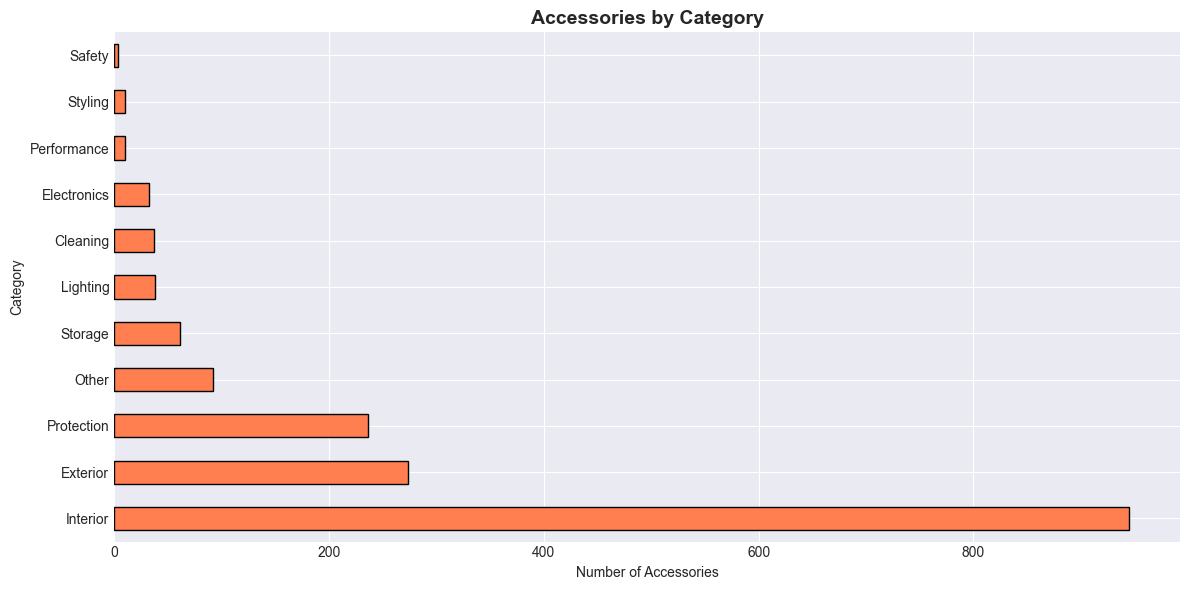


📋 Sample Accessories per Category:

Interior:
  1. 10D Car Floor Mat Full Set
  2. 10D Car Foot Mat
  3. 10D Car Foot Mat (Tan with Black)

Exterior:
  1. 100% Water Resistant Car Body Cover with Mirror (Triple Stitched, Full Bottom Elastic, Black)
  2. 3M Car Care Glass Cleaner
  3. 3M IA260100036 Car care Glass Cleaner (250ml)

Protection:
  1. 3 Pack Screen Guard (10" Infotainment + 8" Cluster + AC Panel)
  2. 3M Premium Liquid Wax (200ml)
  3. 9H Screen Guard for BMW i7 2025 Infotainment

Other:
  1. Able 3D-FIX Sun Shade Curtain Set
  2. Able Zed Black Half Car Sun Shade Curtains
  3. ABS Roll Bar Black Powder-Coated

Storage:
  1. ABLE 3D-FIX Type Car Non-Magnetic Sun Shade Curtains
  2. Able 3D-FIX Type Car Non-Magnetic Sun Shade Curtains
  3. Able Dotnet Magnetic Sun Shade Curtains

✅ Created Category feature for accessories


In [4]:
print("=" * 80)
print("CREATING ACCESSORY CATEGORIES")
print("=" * 80)

# Define category keywords
category_keywords = {
    'Interior': ['seat', 'mat', 'cover', 'cushion', 'steering', 'dashboard', 'carpet', 'organizer', 'holder'],
    'Exterior': ['bumper', 'grill', 'spoiler', 'chrome', 'body', 'door', 'window', 'mirror', 'visor', 'deflector'],
    'Protection': ['guard', 'protector', 'film', 'shield', 'scratch', 'dent', 'mudflap', 'splash'],
    'Lighting': ['light', 'led', 'lamp', 'bulb', 'fog', 'drl', 'headlight', 'taillight'],
    'Electronics': ['camera', 'sensor', 'bluetooth', 'charger', 'usb', 'adapter', 'dvr', 'dashcam', 'gps'],
    'Storage': ['box', 'trunk', 'cargo', 'net', 'bag', 'case', 'rack'],
    'Cleaning': ['cleaner', 'polish', 'wax', 'wash', 'shampoo', 'detergent'],
    'Safety': ['camera', 'sensor', 'alarm', 'lock', 'airbag', 'seatbelt', 'child', 'baby'],
    'Performance': ['filter', 'oil', 'brake', 'clutch', 'suspension', 'tire', 'wheel', 'rim'],
    'Styling': ['sticker', 'decal', 'badge', 'emblem', 'trim', 'accent']
}

def categorize_accessory(name, description):
    """Categorize accessory based on name and description"""
    text = f"{str(name)} {str(description)}".lower()
    
    # Check each category
    category_scores = {}
    for category, keywords in category_keywords.items():
        score = sum(1 for keyword in keywords if keyword in text)
        if score > 0:
            category_scores[category] = score
    
    # Return category with highest score, or 'Other'
    if category_scores:
        return max(category_scores, key=category_scores.get)
    else:
        return 'Other'

# Apply categorization
df_accessories['Category'] = df_accessories.apply(
    lambda row: categorize_accessory(row['Accessory Name'], row['Accessory Description']),
    axis=1
)

print(f"\n📊 Accessory Category Distribution:")
category_counts = df_accessories['Category'].value_counts()
print(category_counts)

# Visualize
plt.figure(figsize=(12, 6))
category_counts.plot(kind='barh', color='coral', edgecolor='black')
plt.title('Accessories by Category', fontsize=14, fontweight='bold')
plt.xlabel('Number of Accessories')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

# Show sample accessories per category
print(f"\n📋 Sample Accessories per Category:")
for category in category_counts.head(5).index:
    print(f"\n{category}:")
    samples = df_accessories[df_accessories['Category'] == category]['Accessory Name'].head(3).tolist()
    for i, sample in enumerate(samples, 1):
        print(f"  {i}. {sample}")

print(f"\n✅ Created Category feature for accessories")

## 5. Process Reviews for Sentiment Analysis

In [5]:
print("=" * 80)
print("PROCESSING REVIEWS")
print("=" * 80)

# Split reviews into individual reviews
def split_reviews(review_string):
    """Split pipe-separated reviews into list"""
    if pd.isna(review_string):
        return []
    reviews = str(review_string).split('|')
    # Clean and filter
    cleaned = [r.strip() for r in reviews if r.strip() and len(r.strip()) > 10]
    return cleaned

# Create review count feature
df_accessories['Review_List'] = df_accessories['Top 5 Reviews'].apply(split_reviews)
df_accessories['Review_Count'] = df_accessories['Review_List'].apply(len)

print(f"\n📊 Review Statistics:")
print(f"   Accessories with reviews: {(df_accessories['Review_Count'] > 0).sum()}")
print(f"   Accessories without reviews: {(df_accessories['Review_Count'] == 0).sum()}")
print(f"   Total reviews: {df_accessories['Review_Count'].sum()}")
print(f"   Average reviews per accessory: {df_accessories['Review_Count'].mean():.2f}")

# Review count distribution
print(f"\n📈 Review Count Distribution:")
print(df_accessories['Review_Count'].value_counts().sort_index())

# Combine all reviews into single text for each accessory
df_accessories['Reviews_Combined'] = df_accessories['Review_List'].apply(
    lambda reviews: ' '.join(reviews) if reviews else ''
)

# Calculate review text length
df_accessories['Review_Text_Length'] = df_accessories['Reviews_Combined'].apply(len)

print(f"\n✅ Created Review_Count and Reviews_Combined features")
print(f"\n📋 Sample reviews:")
sample = df_accessories[df_accessories['Review_Count'] > 0].iloc[0]
print(f"Accessory: {sample['Accessory Name']}")
print(f"Review count: {sample['Review_Count']}")
print(f"Reviews:")
for i, review in enumerate(sample['Review_List'][:3], 1):
    print(f"  {i}. {review[:100]}...")

PROCESSING REVIEWS

📊 Review Statistics:
   Accessories with reviews: 1726
   Accessories without reviews: 13
   Total reviews: 5705
   Average reviews per accessory: 3.28

📈 Review Count Distribution:
Review_Count
0     13
1    540
2     74
3    140
4    278
5    686
6      3
7      3
8      2
Name: count, dtype: int64

✅ Created Review_Count and Reviews_Combined features

📋 Sample reviews:
Accessory: 100% Water Resistant Car Body Cover with Mirror (Triple Stitched, Full Bottom Elastic, Black)
Review count: 5
Reviews:
  1. Superb Quality Product: strong protection, waterproof, easy install....
  2. Ok, cloth quality good but not waterproof....
  3. Best for ignis car at reasonable price....


## 6. Create TF-IDF Features from Descriptions

In [6]:
print("=" * 80)
print("CREATING TF-IDF FEATURES")
print("=" * 80)

# Combine description and name for better feature extraction
df_accessories['Full_Text'] = (
    df_accessories['Accessory Name'].fillna('') + ' ' + 
    df_accessories['Accessory Description'].fillna('')
)

print(f"\n🔤 Creating TF-IDF features...")

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=100,  # Top 100 features
    stop_words='english',
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,  # Minimum document frequency
    max_df=0.8  # Maximum document frequency
)

# Fit and transform
tfidf_matrix = tfidf.fit_transform(df_accessories['Full_Text'])

print(f"\n✅ TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"   Documents: {tfidf_matrix.shape[0]}")
print(f"   Features: {tfidf_matrix.shape[1]}")

# Get top terms
feature_names = tfidf.get_feature_names_out()
print(f"\n📋 Top 30 TF-IDF Terms:")
for i, term in enumerate(feature_names[:30], 1):
    print(f"  {i:2}. {term}")

# Save TF-IDF features as DataFrame
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=[f'tfidf_{term}' for term in feature_names],
    index=df_accessories.index
)

print(f"\n✅ Created {len(feature_names)} TF-IDF features")

# Show sample TF-IDF scores
print(f"\n📊 Sample TF-IDF Scores (first 5 features):")
print(tfidf_df.iloc[:5, :5])

CREATING TF-IDF FEATURES

🔤 Creating TF-IDF features...

✅ TF-IDF Matrix Shape: (1739, 100)
   Documents: 1739
   Features: 100

📋 Top 30 TF-IDF Terms:
   1. 100
   2. 100 waterproof
   3. 7d
   4. 7d car
   5. abs
   6. anti
   7. anti scratch
   8. anti skid
   9. anti slip
  10. black
  11. bmw
  12. body
  13. body cover
  14. boot
  15. button
  16. car
  17. car body
  18. car cover
  19. car floor
  20. carbon
  21. chrome
  22. clean
  23. color
  24. compatible
  25. cover
  26. custom
  27. custom fit
  28. design
  29. door
  30. double

✅ Created 100 TF-IDF features

📊 Sample TF-IDF Scores (first 5 features):
   tfidf_100  tfidf_100 waterproof  tfidf_7d  tfidf_7d car  tfidf_abs
0   0.214688              0.000000       0.0           0.0        0.0
1   0.312742              0.343879       0.0           0.0        0.0
2   0.000000              0.000000       0.0           0.0        0.0
3   0.000000              0.000000       0.0           0.0        0.0
4   0.000000         

## 7. Create Brand Popularity Features

In [7]:
print("=" * 80)
print("CREATING BRAND POPULARITY FEATURES")
print("=" * 80)

# Calculate brand popularity based on accessory count
brand_counts = df_accessories['Car Brand'].value_counts()
brand_popularity = brand_counts / brand_counts.sum()

print(f"\n📊 Top 10 Brands by Accessory Count:")
print(brand_counts.head(10))

# Map popularity to accessories
df_accessories['Brand_Popularity'] = df_accessories['Car Brand'].map(brand_popularity)

# Create popularity categories
def categorize_popularity(score):
    if pd.isna(score):
        return 'Unknown'
    elif score < 0.01:
        return 'Niche'
    elif score < 0.03:
        return 'Low'
    elif score < 0.06:
        return 'Medium'
    elif score < 0.10:
        return 'High'
    else:
        return 'Very High'

df_accessories['Brand_Popularity_Category'] = df_accessories['Brand_Popularity'].apply(categorize_popularity)

print(f"\n📈 Brand Popularity Distribution:")
print(df_accessories['Brand_Popularity_Category'].value_counts())

# Map to cars dataset as well
df_cars['Brand_Accessory_Count'] = df_cars['Brand'].map(brand_counts).fillna(0)

print(f"\n📊 Cars with Most Accessories:")
print(df_cars.nlargest(10, 'Brand_Accessory_Count')[['Brand', 'Model', 'Brand_Accessory_Count']])

print(f"\n✅ Created Brand_Popularity and Brand_Accessory_Count features")

CREATING BRAND POPULARITY FEATURES

📊 Top 10 Brands by Accessory Count:
Car Brand
Maruti Suzuki    171
Bmw              163
Audi             146
Hyundai          138
Toyota           112
Tata              96
Mahindra          93
Jaguar            64
Skoda             63
Rolls Royce       58
Name: count, dtype: int64

📈 Brand Popularity Distribution:
Brand_Popularity_Category
High      730
Medium    430
Low       412
Niche     167
Name: count, dtype: int64

📊 Cars with Most Accessories:
             Brand         Model  Brand_Accessory_Count
100  Maruti Suzuki   Ertiga Tour                  171.0
101  Maruti Suzuki  Grand Vitara                  171.0
102  Maruti Suzuki           XL6                  171.0
103  Maruti Suzuki         Jimny                  171.0
104  Maruti Suzuki       Invicto                  171.0
105  Maruti Suzuki      Alto K10                  171.0
106  Maruti Suzuki      S-Presso                  171.0
107  Maruti Suzuki  Alto Tour H1                  171.0
108  

## 8. Create Numeric Encodings

In [8]:
print("=" * 80)
print("CREATING NUMERIC ENCODINGS")
print("=" * 80)

# Label encode categorical variables for ML models
le_fuel = LabelEncoder()
le_transmission = LabelEncoder()
le_body = LabelEncoder()

df_cars['Fuel_Type_Encoded'] = le_fuel.fit_transform(df_cars['Fuel_Type'])
df_cars['Transmission_Encoded'] = le_transmission.fit_transform(df_cars['Transmission'])
df_cars['Body_Type_Encoded'] = le_body.fit_transform(df_cars['Body_Type'])

print(f"\n✅ Created encoded features for cars:")
print(f"   Fuel_Type_Encoded: {df_cars['Fuel_Type_Encoded'].nunique()} categories")
print(f"   Transmission_Encoded: {df_cars['Transmission_Encoded'].nunique()} categories")
print(f"   Body_Type_Encoded: {df_cars['Body_Type_Encoded'].nunique()} categories")

# Encode accessory categories
le_category = LabelEncoder()
df_accessories['Category_Encoded'] = le_category.fit_transform(df_accessories['Category'])

print(f"\n✅ Created encoded feature for accessories:")
print(f"   Category_Encoded: {df_accessories['Category_Encoded'].nunique()} categories")

# Show encoding mappings
print(f"\n📋 Encoding Mappings:")
print(f"\nFuel Type:")
for i, fuel in enumerate(le_fuel.classes_):
    print(f"  {i}: {fuel}")

print(f"\nTransmission:")
for i, trans in enumerate(le_transmission.classes_):
    print(f"  {i}: {trans}")

print(f"\nBody Type (first 10):")
for i, body in enumerate(le_body.classes_[:10]):
    print(f"  {i}: {body}")

CREATING NUMERIC ENCODINGS

✅ Created encoded features for cars:
   Fuel_Type_Encoded: 6 categories
   Transmission_Encoded: 14 categories
   Body_Type_Encoded: 23 categories

✅ Created encoded feature for accessories:
   Category_Encoded: 11 categories

📋 Encoding Mappings:

Fuel Type:
  0: Diesel
  1: Electric
  2: Hybrid
  3: Petrol
  4: Petrol/CNG
  5: Petrol/Diesel/CNG

Transmission:
  0: AT
  1: CVT
  2: DCT
  3: MANUAL/AMT
  4: MANUAL/AMT/DCT
  5: MANUAL/AT
  6: MANUAL/AT/CVT
  7: MANUAL/CVT
  8: MANUAL/CVT/AT
  9: MANUAL/CVT/DCT
  10: MANUAL/DCT
  11: MANUAL/DCT/AMT
  12: MANUAL/DCT/AT
  13: MT

Body Type (first 10):
  0: Commercial
  1: Compact SUV
  2: Convertible
  3: Coupe
  4: Coupe SUV
  5: Electric Coupe
  6: Electric Hatchback
  7: Electric MUV
  8: Electric SUV
  9: Electric Sedan


## 9. Feature Summary Statistics

In [9]:
print("=" * 80)
print("FEATURE SUMMARY")
print("=" * 80)

print("\n📊 CARS DATASET FEATURES:")
print(f"   Total features: {len(df_cars.columns)}")
print(f"   Original features: Brand, Model, Fuel_Type, Transmission, Year, Engine_Size_L, Seats, Body_Type, Price_Range_Lakh")
print(f"\n   NEW Features Created:")
new_car_features = [
    'Price_Min_Lakh', 'Price_Max_Lakh', 'Price_Mid_Lakh', 'Price_Segment',
    'Fuel_Type_Encoded', 'Transmission_Encoded', 'Body_Type_Encoded',
    'Brand_Accessory_Count'
]
for i, feat in enumerate(new_car_features, 1):
    print(f"   {i:2}. {feat}")

print("\n📊 ACCESSORIES DATASET FEATURES:")
print(f"   Total features: {len(df_accessories.columns)} (excluding TF-IDF)")
print(f"   Original features: Car Brand, Car Model, Accessory Name, Accessory Price, Accessory Description, Compatible Cars, Top 5 Reviews, Accessory_ID")
print(f"\n   NEW Features Created:")
new_acc_features = [
    'Price_Segment', 'Category', 'Review_List', 'Review_Count',
    'Reviews_Combined', 'Review_Text_Length', 'Full_Text',
    'Brand_Popularity', 'Brand_Popularity_Category', 'Category_Encoded'
]
for i, feat in enumerate(new_acc_features, 1):
    print(f"   {i:2}. {feat}")

print(f"\n   TF-IDF Features: {tfidf_matrix.shape[1]} features")

print("\n📈 FEATURE STATISTICS:")
print(f"\nCars - Numeric Features:")
numeric_cols_cars = ['Year', 'Engine_Size_L', 'Seats', 'Price_Min_Lakh', 'Price_Max_Lakh', 'Price_Mid_Lakh']
print(df_cars[numeric_cols_cars].describe())

print(f"\nAccessories - Numeric Features:")
numeric_cols_acc = ['Accessory Price', 'Review_Count', 'Review_Text_Length', 'Brand_Popularity']
print(df_accessories[numeric_cols_acc].describe())

FEATURE SUMMARY

📊 CARS DATASET FEATURES:
   Total features: 19
   Original features: Brand, Model, Fuel_Type, Transmission, Year, Engine_Size_L, Seats, Body_Type, Price_Range_Lakh

   NEW Features Created:
    1. Price_Min_Lakh
    2. Price_Max_Lakh
    3. Price_Mid_Lakh
    4. Price_Segment
    5. Fuel_Type_Encoded
    6. Transmission_Encoded
    7. Body_Type_Encoded
    8. Brand_Accessory_Count

📊 ACCESSORIES DATASET FEATURES:
   Total features: 19 (excluding TF-IDF)
   Original features: Car Brand, Car Model, Accessory Name, Accessory Price, Accessory Description, Compatible Cars, Top 5 Reviews, Accessory_ID

   NEW Features Created:
    1. Price_Segment
    2. Category
    3. Review_List
    4. Review_Count
    5. Reviews_Combined
    6. Review_Text_Length
    7. Full_Text
    8. Brand_Popularity
    9. Brand_Popularity_Category
   10. Category_Encoded

   TF-IDF Features: 100 features

📈 FEATURE STATISTICS:

Cars - Numeric Features:
         Year  Engine_Size_L       Seats  Price

## 10. Visualize Feature Relationships

VISUALIZING FEATURE RELATIONSHIPS


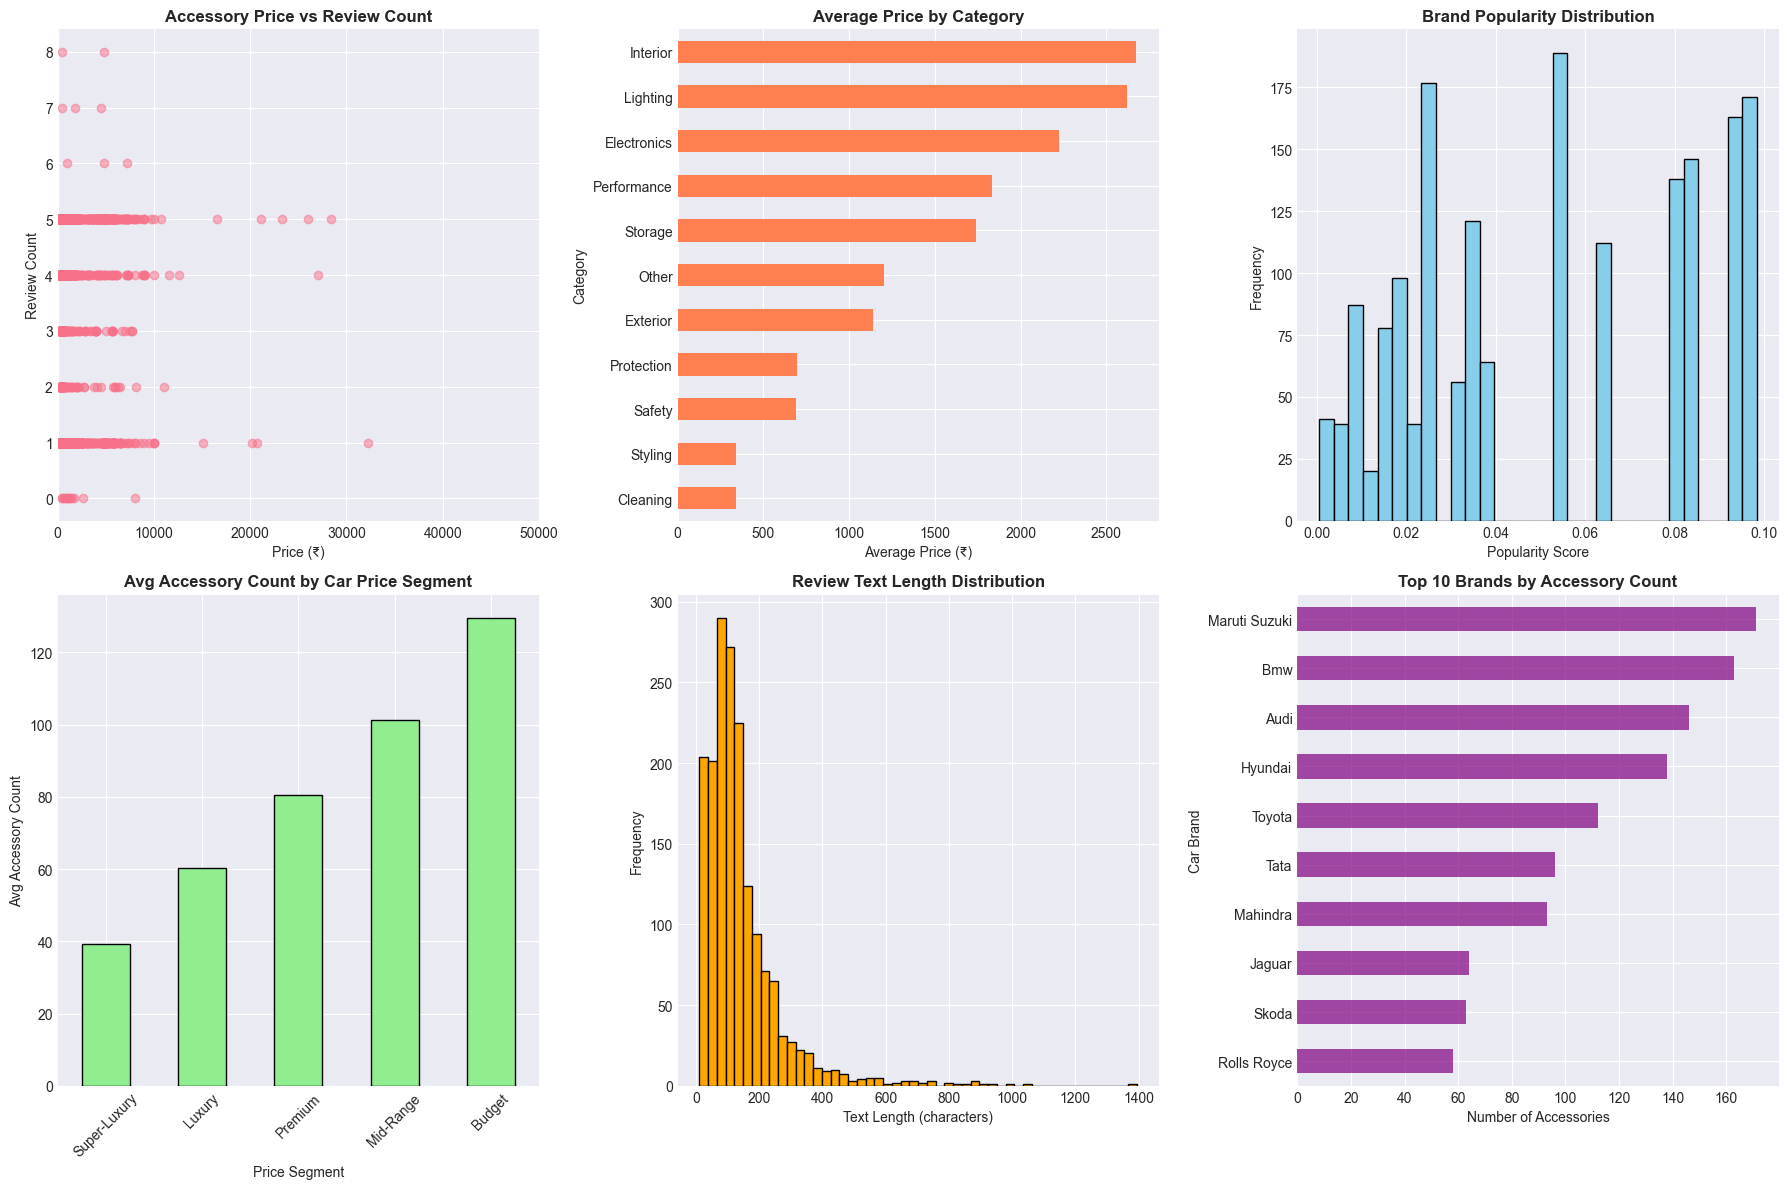


✅ Visualizations created successfully!


In [10]:
print("=" * 80)
print("VISUALIZING FEATURE RELATIONSHIPS")
print("=" * 80)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Price vs Review Count
axes[0, 0].scatter(df_accessories['Accessory Price'], df_accessories['Review_Count'], alpha=0.5)
axes[0, 0].set_title('Accessory Price vs Review Count', fontweight='bold')
axes[0, 0].set_xlabel('Price (₹)')
axes[0, 0].set_ylabel('Review Count')
axes[0, 0].set_xlim(0, 50000)

# 2. Category vs Average Price
category_price = df_accessories.groupby('Category')['Accessory Price'].mean().sort_values()
category_price.plot(kind='barh', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Average Price by Category', fontweight='bold')
axes[0, 1].set_xlabel('Average Price (₹)')

# 3. Brand Popularity Distribution
axes[0, 2].hist(df_accessories['Brand_Popularity'], bins=30, color='skyblue', edgecolor='black')
axes[0, 2].set_title('Brand Popularity Distribution', fontweight='bold')
axes[0, 2].set_xlabel('Popularity Score')
axes[0, 2].set_ylabel('Frequency')

# 4. Car Price Segments vs Accessory Count
price_seg_counts = df_cars.groupby('Price_Segment')['Brand_Accessory_Count'].mean().sort_values()
price_seg_counts.plot(kind='bar', ax=axes[1, 0], color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Avg Accessory Count by Car Price Segment', fontweight='bold')
axes[1, 0].set_xlabel('Price Segment')
axes[1, 0].set_ylabel('Avg Accessory Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Review Text Length Distribution
axes[1, 1].hist(df_accessories[df_accessories['Review_Text_Length'] > 0]['Review_Text_Length'], 
                bins=50, color='orange', edgecolor='black')
axes[1, 1].set_title('Review Text Length Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Text Length (characters)')
axes[1, 1].set_ylabel('Frequency')

# 6. Top Brands by Accessory Count
top_brands = df_accessories['Car Brand'].value_counts().head(10)
top_brands.plot(kind='barh', ax=axes[1, 2], color='purple', alpha=0.7)
axes[1, 2].set_title('Top 10 Brands by Accessory Count', fontweight='bold')
axes[1, 2].set_xlabel('Number of Accessories')
axes[1, 2].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n✅ Visualizations created successfully!")

## 11. Save Engineered Features

In [11]:
print("=" * 80)
print("SAVING ENGINEERED FEATURES")
print("=" * 80)

# Drop temporary columns that won't be used in ML
columns_to_drop_acc = ['Review_List', 'Full_Text']
df_accessories_save = df_accessories.drop(columns=columns_to_drop_acc)

# Save main datasets with features
df_cars.to_csv('../../Dataset/processed/cars_with_features.csv', index=False)
df_accessories_save.to_csv('../../Dataset/processed/accessories_with_features.csv', index=False)

print(f"\n✅ Saved cars_with_features.csv ({len(df_cars)} rows, {len(df_cars.columns)} columns)")
print(f"✅ Saved accessories_with_features.csv ({len(df_accessories_save)} rows, {len(df_accessories_save.columns)} columns)")

# Save TF-IDF features separately
tfidf_df.to_csv('../../Dataset/processed/accessories_tfidf_features.csv', index=True)
print(f"✅ Saved accessories_tfidf_features.csv ({tfidf_df.shape[0]} rows, {tfidf_df.shape[1]} features)")

# Save label encoders for future use
import pickle

encoders = {
    'fuel_type': le_fuel,
    'transmission': le_transmission,
    'body_type': le_body,
    'category': le_category
}

with open('../../Dataset/processed/label_encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

print(f"✅ Saved label_encoders.pkl")

# Save TF-IDF vectorizer
with open('../../Dataset/processed/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print(f"✅ Saved tfidf_vectorizer.pkl")

# Create feature engineering summary
summary = f"""# Feature Engineering Summary
**Date**: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

## Cars Dataset
- Total rows: {len(df_cars)}
- Total features: {len(df_cars.columns)}
- New features: {len(new_car_features)}

### Price Features
- Price_Min_Lakh, Price_Max_Lakh, Price_Mid_Lakh
- Price_Segment: {df_cars['Price_Segment'].value_counts().to_dict()}

### Encoded Features
- Fuel_Type_Encoded: {df_cars['Fuel_Type_Encoded'].nunique()} categories
- Transmission_Encoded: {df_cars['Transmission_Encoded'].nunique()} categories
- Body_Type_Encoded: {df_cars['Body_Type_Encoded'].nunique()} categories

### Brand Features
- Brand_Accessory_Count: Average {df_cars['Brand_Accessory_Count'].mean():.1f} accessories per brand

## Accessories Dataset
- Total rows: {len(df_accessories)}
- Total features: {len(df_accessories_save.columns)} (+ {tfidf_matrix.shape[1]} TF-IDF features)
- New features: {len(new_acc_features)}

### Price Features
- Price_Segment: {df_accessories['Price_Segment'].value_counts().to_dict()}

### Category Features
- Category: {df_accessories['Category'].nunique()} categories
- Top categories: {df_accessories['Category'].value_counts().head(5).to_dict()}

### Review Features
- Accessories with reviews: {(df_accessories['Review_Count'] > 0).sum()}
- Total reviews: {df_accessories['Review_Count'].sum()}
- Average reviews per accessory: {df_accessories['Review_Count'].mean():.2f}

### Text Features
- TF-IDF features: {tfidf_matrix.shape[1]}
- Vocabulary size: {len(tfidf.vocabulary_)}

### Brand Features
- Brand_Popularity: Calculated based on accessory frequency
- Top brands: {brand_counts.head(5).to_dict()}

## Files Saved
1. `cars_with_features.csv` - Cars dataset with all features
2. `accessories_with_features.csv` - Accessories dataset with all features
3. `accessories_tfidf_features.csv` - TF-IDF feature matrix
4. `label_encoders.pkl` - Label encoders for categorical variables
5. `tfidf_vectorizer.pkl` - Fitted TF-IDF vectorizer

## Next Steps
- Phase 2: Sentiment Analysis on reviews
- Phase 3: Build recommendation engine using these features
"""

with open('../../Dataset/processed/feature_engineering_summary.md', 'w', encoding='utf-8') as f:
    f.write(summary)

print(f"✅ Saved feature_engineering_summary.md")

print("\n" + "=" * 80)
print("✅ FEATURE ENGINEERING COMPLETE!")
print("=" * 80)
print(f"\n📁 All files saved to: Dataset/processed/")
print(f"\n🎯 Ready for Phase 2: Sentiment Analysis!")

SAVING ENGINEERED FEATURES

✅ Saved cars_with_features.csv (205 rows, 19 columns)
✅ Saved accessories_with_features.csv (1739 rows, 17 columns)
✅ Saved accessories_tfidf_features.csv (1739 rows, 100 features)
✅ Saved label_encoders.pkl
✅ Saved tfidf_vectorizer.pkl
✅ Saved feature_engineering_summary.md

✅ FEATURE ENGINEERING COMPLETE!

📁 All files saved to: Dataset/processed/

🎯 Ready for Phase 2: Sentiment Analysis!
